**Data Exploration: Supply Chain Delay Analysis**

This Jupyter notebook provides a comprehensive exploration of supply chain shipment data. It is designed to give a clear understanding of shipment delays, patterns, and trends across various dimensions such as region, shipment mode, product department, customer market, and more.

Each code block is structured to display its results immediately, allowing anyone who views the notebook to see the outputs—whether visualizations, summary statistics, or key metrics—without needing to dig into the code. This makes it easier to follow the analysis and understand where delays are most frequent, how different factors contribute to them, and the overall performance of the supply chai

In [ ]:

import os

# pylint: disable=import-error
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import pandas as pd  # type: ignore
import plotly.express as px  # type: ignore
import seaborn as sns  # type: ignore

In [4]:
try:
    plt.style.use("seaborn-v0_8")
except OSError:
    try:
        plt.style.use("seaborn")
    except OSError:
        plt.style.use("default")
sns.set_palette("husl")

In [5]:


from google.colab import files
uploaded = files.upload()

df = pd.read_csv("orders_and_shipments_final_cleaned.csv")
print("Data loaded successfully!")

Saving orders_and_shipments_final_cleaned.csv to orders_and_shipments_final_cleaned.csv
Data loaded successfully!


In [6]:
# Validate required columns exist
required_columns = [
    "Order Date",
    "Shipment Date",
    "Shipment Days - Scheduled",
    "Region",
    "Shipment Mode",
    "Product Department",
    "Product Category",
    "Customer Market",
    "Warehouse Country",
    "Customer Country",
    "Order Quantity",
]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise KeyError(
        f"Missing required columns in dataset: {missing_columns}\n"
        f"Available columns: {list(df.columns)}"
    )

In [7]:
# Basic data exploration
print("=== DATA OVERVIEW ===")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\n=== DATA TYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

print("\n=== BASIC STATISTICS ===")
print(df.describe())


=== DATA OVERVIEW ===
Dataset shape: (30871, 14)

First few rows:
  Order Time  Order Quantity Product Department Product Category  \
0      14:07               1           Fan Shop          Fishing   
1       7:37               1           Fan Shop          Fishing   
2      22:47               1           Fan Shop          Fishing   
3      22:32               1           Fan Shop          Fishing   
4      22:32               1           Fan Shop          Fishing   

                                Product Name Customer Market  Customer Region  \
0  Field & Stream Sportsman 16 Gun Fire Safe           LATAM  Central America   
1  Field & Stream Sportsman 16 Gun Fire Safe           LATAM    South America   
2  Field & Stream Sportsman 16 Gun Fire Safe           LATAM  Central America   
3  Field & Stream Sportsman 16 Gun Fire Safe          Europe  Northern Europe   
4  Field & Stream Sportsman 16 Gun Fire Safe          Europe  Northern Europe   

  Customer Country Warehouse Country  

In [ ]:
# Data preprocessing
# Convert date columns to datetime
print("\n=== DATA PREPROCESSING ===")
try:
    df["Order Date"] = pd.to_datetime(
        df["Order Date"], format="%m/%d/%Y", errors="coerce"
    )
    df["Shipment Date"] = pd.to_datetime(
        df["Shipment Date"], format="%m/%d/%Y", errors="coerce"
    )
    invalid_dates = df["Order Date"].isna().sum() + df["Shipment Date"].isna().sum()
    if invalid_dates > 0:
        print(
            f"Warning: {invalid_dates} rows have invalid dates that could not be parsed"
        )
except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:
    print(f"Warning: Date parsing with format failed: {e}")
    print("Attempting to parse dates without specific format...")
    df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
    df["Shipment Date"] = pd.to_datetime(df["Shipment Date"], errors="coerce")

# Calculate actual shipment days (handle NaT values)
df["Shipment Days - Actual"] = (df["Shipment Date"] - df["Order Date"]).dt.days

# DISPLAY RESULTS in Jupyter Notebook
from IPython.display import display  # noqa: E402

# Show first 10 rows to check the dates and shipment days
print("\nSample of processed data:")
display(df[["Order Date", "Shipment Date", "Shipment Days - Actual"]].head(10))

# Optional: summary statistics
print("\nSummary statistics for actual shipment days:")
display(df["Shipment Days - Actual"].describe())



=== DATA PREPROCESSING ===

Sample of processed data:


,Order Date,Shipment Date,Shipment Days - Actual
0,2015-02-21,2015-02-27,6
1,2015-03-02,2015-03-06,4
2,2015-04-18,2015-04-20,2
3,2015-06-10,2015-06-12,2
4,2015-06-10,2015-06-12,2
5,2015-06-10,2015-06-12,2
6,2015-10-09,2015-10-13,4
7,2015-10-13,2015-10-15,2
8,2015-11-06,2015-11-12,6
9,2015-11-15,2015-11-17,2



Summary statistics for actual shipment days:


,Shipment Days - Actual
count,30871.000000
mean,3.560753
std,131.195817
min,-975.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,978.000000


In [ ]:
# Validate that scheduled days is numeric
if not pd.api.types.is_numeric_dtype(df["Shipment Days - Scheduled"]):
    print("Warning: Converting 'Shipment Days - Scheduled' to numeric...")
    df["Shipment Days - Scheduled"] = pd.to_numeric(
        df["Shipment Days - Scheduled"], errors="coerce"
    )

# DISPLAY RESULTS in Jupyter Notebook
from IPython.display import display  # noqa: E402

print("\nSample of 'Shipment Days - Scheduled' after conversion:")
display(df[["Shipment Days - Scheduled"]].head(10))

print("\nSummary statistics for 'Shipment Days - Scheduled':")
display(df["Shipment Days - Scheduled"].describe())



Sample of 'Shipment Days - Scheduled' after conversion:


,Shipment Days - Scheduled
0,4
1,4
2,4
3,4
4,4
5,4
6,4
7,4
8,4
9,4



Summary statistics for 'Shipment Days - Scheduled':


,Shipment Days - Scheduled
count,30871.000000
mean,3.072495
std,1.184417
min,1.000000
25%,2.000000
50%,4.000000
75%,4.000000
max,4.000000


In [ ]:
# Calculate delay (positive = delayed, negative = early)
df["Delay Days"] = df["Shipment Days - Actual"] - df["Shipment Days - Scheduled"]

# Handle any NaN values that might have been introduced
missing_data_count = (
    df[["Order Date", "Shipment Date", "Delay Days"]].isnull().any(axis=1).sum()
)
print(f"\nRows with missing dates or delays: {missing_data_count}")

# DISPLAY some results in Jupyter Notebook
from IPython.display import display  # noqa: E402

print("\nSample of 'Delay Days' column:")
display(df[["Order Date", "Shipment Date", "Shipment Days - Actual", "Shipment Days - Scheduled", "Delay Days"]].head(10))

print("\nSummary statistics for 'Delay Days':")
display(df["Delay Days"].describe())

# Extract month and year for time analysis (only for valid dates)
df["Order Month"] = df["Order Date"].dt.month
df["Order Year"] = df["Order Date"].dt.year
df["Order Month-Year"] = df["Order Date"].dt.to_period("M")

# Handle any NaN values in month/year columns
df["Order Month"] = df["Order Month"].fillna(0).astype(int).replace(0, np.nan)
df["Order Year"] = df["Order Year"].fillna(0).astype(int).replace(0, np.nan)

# DISPLAY month/year extraction
print("\nSample of extracted Month-Year columns:")
display(df[["Order Month", "Order Year", "Order Month-Year"]].head(10))



Rows with missing dates or delays: 0

Sample of 'Delay Days' column:


,Order Date,Shipment Date,Shipment Days - Actual,Shipment Days - Scheduled,Delay Days
0,2015-02-21,2015-02-27,6,4,2
1,2015-03-02,2015-03-06,4,4,0
2,2015-04-18,2015-04-20,2,4,-2
3,2015-06-10,2015-06-12,2,4,-2
4,2015-06-10,2015-06-12,2,4,-2
5,2015-06-10,2015-06-12,2,4,-2
6,2015-10-09,2015-10-13,4,4,0
7,2015-10-13,2015-10-15,2,4,-2
8,2015-11-06,2015-11-12,6,4,2
9,2015-11-15,2015-11-17,2,4,-2



Summary statistics for 'Delay Days':


,Delay Days
count,30871.000000
mean,0.488258
std,131.185705
min,-979.000000
25%,-2.000000
50%,0.000000
75%,2.000000
max,974.000000



Sample of extracted Month-Year columns:


,Order Month,Order Year,Order Month-Year
0,2,2015,2015-02
1,3,2015,2015-03
2,4,2015,2015-04
3,6,2015,2015-06
4,6,2015,2015-06
5,6,2015,2015-06
6,10,2015,2015-10
7,10,2015,2015-10
8,11,2015,2015-11
9,11,2015,2015-11


In [16]:
print("\n=== DELAY STATISTICS ===")
# Use only valid delay values for statistics
valid_delays_stats = df["Delay Days"].dropna()
if len(valid_delays_stats) == 0:
    print("Warning: No valid delay data available!")
    delay_mean = delay_max = delay_min = delay_pct = 0
else:
    delay_mean = valid_delays_stats.mean()
    delay_max = valid_delays_stats.max()
    delay_min = valid_delays_stats.min()
    delay_pct = (valid_delays_stats > 0).mean() * 100

print(f"Average delay: {delay_mean:.2f} days")
print(f"Maximum delay: {delay_max:.2f} days")
print(f"Minimum delay: {delay_min:.2f} days")
print(f"Percentage of delayed shipments: {delay_pct:.2f}%")
print(f"Valid delay records: {df['Delay Days'].notna().sum()} out of {len(df)}")


=== DELAY STATISTICS ===
Average delay: 0.49 days
Maximum delay: 974.00 days
Minimum delay: -979.00 days
Percentage of delayed shipments: 43.54%
Valid delay records: 30871 out of 30871


In [39]:
# Create comprehensive visualizations
def create_supply_chain_visualizations(dataframe):  # pylint: disable=redefined-outer-name
    """
    Create comprehensive visualizations for global supply chain delay analysis
    """
    df = dataframe  # noqa: F841  # pylint: disable=redefined-outer-name
    plt.figure(figsize=(24, 20))

    # 1. Delay distribution
    plt.subplot(3, 3, 1)
    valid_delays_plot = df["Delay Days"].dropna()
    if len(valid_delays_plot) > 0:
        sns.histplot(data=df, x="Delay Days", bins=30, kde=True)
        plt.axvline(x=0, color="red", linestyle="--", label="On Time")
        delay_mean_val = valid_delays_plot.mean()
        plt.axvline(
            x=delay_mean_val,
            color="orange",
            linestyle="--",
            label=f"Mean: {delay_mean_val:.1f}",
        )
    plt.title("Distribution of Shipment Delays", fontsize=16)
    plt.xlabel("Delay Days (Positive = Delayed)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()

    # 2. Delays by region
    plt.subplot(3, 3, 2)
    region_delays = (
        df.groupby("Region")["Delay Days"].mean().dropna().sort_values(ascending=False)
    )
    if len(region_delays) > 0:
        sns.barplot(x=region_delays.values, y=region_delays.index)
    plt.title("Average Delay by Region", fontsize=16)
    plt.xlabel("Average Delay Days", fontsize=14)
    plt.ylabel("", fontsize=14)

    # 3. Delays by shipment mode
    plt.subplot(3, 3, 3)
    mode_delays = (
        df.groupby("Shipment Mode")["Delay Days"]
        .mean()
        .dropna()
        .sort_values(ascending=False)
    )
    if len(mode_delays) > 0:
        sns.barplot(x=mode_delays.values, y=mode_delays.index)
    plt.title("Average Delay by Shipment Mode", fontsize=16)
    plt.xlabel("Average Delay Days", fontsize=14)

    # 4. Delays by product department
    plt.subplot(3, 3, 4)
    dept_delays = (
        df.groupby("Product Department")["Delay Days"]
        .mean()
        .dropna()
        .sort_values(ascending=False)
    )
    if len(dept_delays) > 0:
        sns.barplot(x=dept_delays.values, y=dept_delays.index)
    plt.title("Average Delay by Product Department", fontsize=16)
    plt.xlabel("Average Delay Days", fontsize=14)

    # 5. Monthly trend of delays
    plt.subplot(3, 3, 5)
    monthly_delays = df.groupby("Order Month-Year")["Delay Days"].mean().dropna()
    if len(monthly_delays) > 0:
        monthly_delays.plot(kind="line", marker="o")
    plt.title("Monthly Trend of Average Delays", fontsize=16)
    plt.xlabel("Month-Year", fontsize=14)
    plt.ylabel("Average Delay Days", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.3)

    # 6. Delay by customer market
    plt.subplot(3, 3, 6)
    market_delays = (
        df.groupby("Customer Market")["Delay Days"]
        .mean()
        .dropna()
        .sort_values(ascending=False)
    )
    if len(market_delays) > 0:
        sns.barplot(x=market_delays.values, y=market_delays.index)
    plt.title("Average Delay by Customer Market", fontsize=16)
    plt.xlabel("Average Delay Days", fontsize=14)

    # 7. Scheduled vs Actual shipment days
    plt.subplot(3, 3, 7)
    valid_data = df[["Shipment Days - Scheduled", "Shipment Days - Actual"]].dropna()
    if len(valid_data) > 0:
        plt.scatter(
            valid_data["Shipment Days - Scheduled"],
            valid_data["Shipment Days - Actual"],
            alpha=0.6,
        )
        max_val = valid_data["Shipment Days - Scheduled"].max()
        plt.plot([0, max_val], [0, max_val], "r--", label="Perfect Schedule")
        plt.legend()
    plt.xlabel("Scheduled Shipment Days", fontsize=14)
    plt.ylabel("Actual Shipment Days", fontsize=14)
    plt.title("Scheduled vs Actual Shipment Days", fontsize=16)

    # 8. Delay patterns by warehouse country
    plt.subplot(3, 3, 8)
    warehouse_delays = (
        df.groupby("Warehouse Country")["Delay Days"]
        .mean()
        .dropna()
        .sort_values(ascending=False)
    )
    if len(warehouse_delays) > 0:
        warehouse_delays = warehouse_delays.head(20)
        sns.barplot(x=warehouse_delays.values, y=warehouse_delays.index)
    plt.title("Average Delay by Warehouse Country", fontsize=16)
    plt.xlabel("Average Delay Days", fontsize=14)

    # 9. Order quantity vs delay
    plt.subplot(3, 3, 9)
    quantity_delays = df.groupby("Order Quantity")["Delay Days"].mean().dropna()
    if len(quantity_delays) > 0:
        quantity_delays = quantity_delays.head(20)
        sns.barplot(x=quantity_delays.index, y=quantity_delays.values)
        plt.title("Average Delay by Order Quantity (Top 20)", fontsize=16)
        plt.xlabel("Order Quantity", fontsize=14)
        plt.ylabel("Average Delay Days", fontsize=14)
    else:
        plt.text(
            0.5,
            0.5,
            "No data available",
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
        )
        plt.title("Average Delay by Order Quantity", fontsize=16)

    plt.tight_layout()
    plt.show()


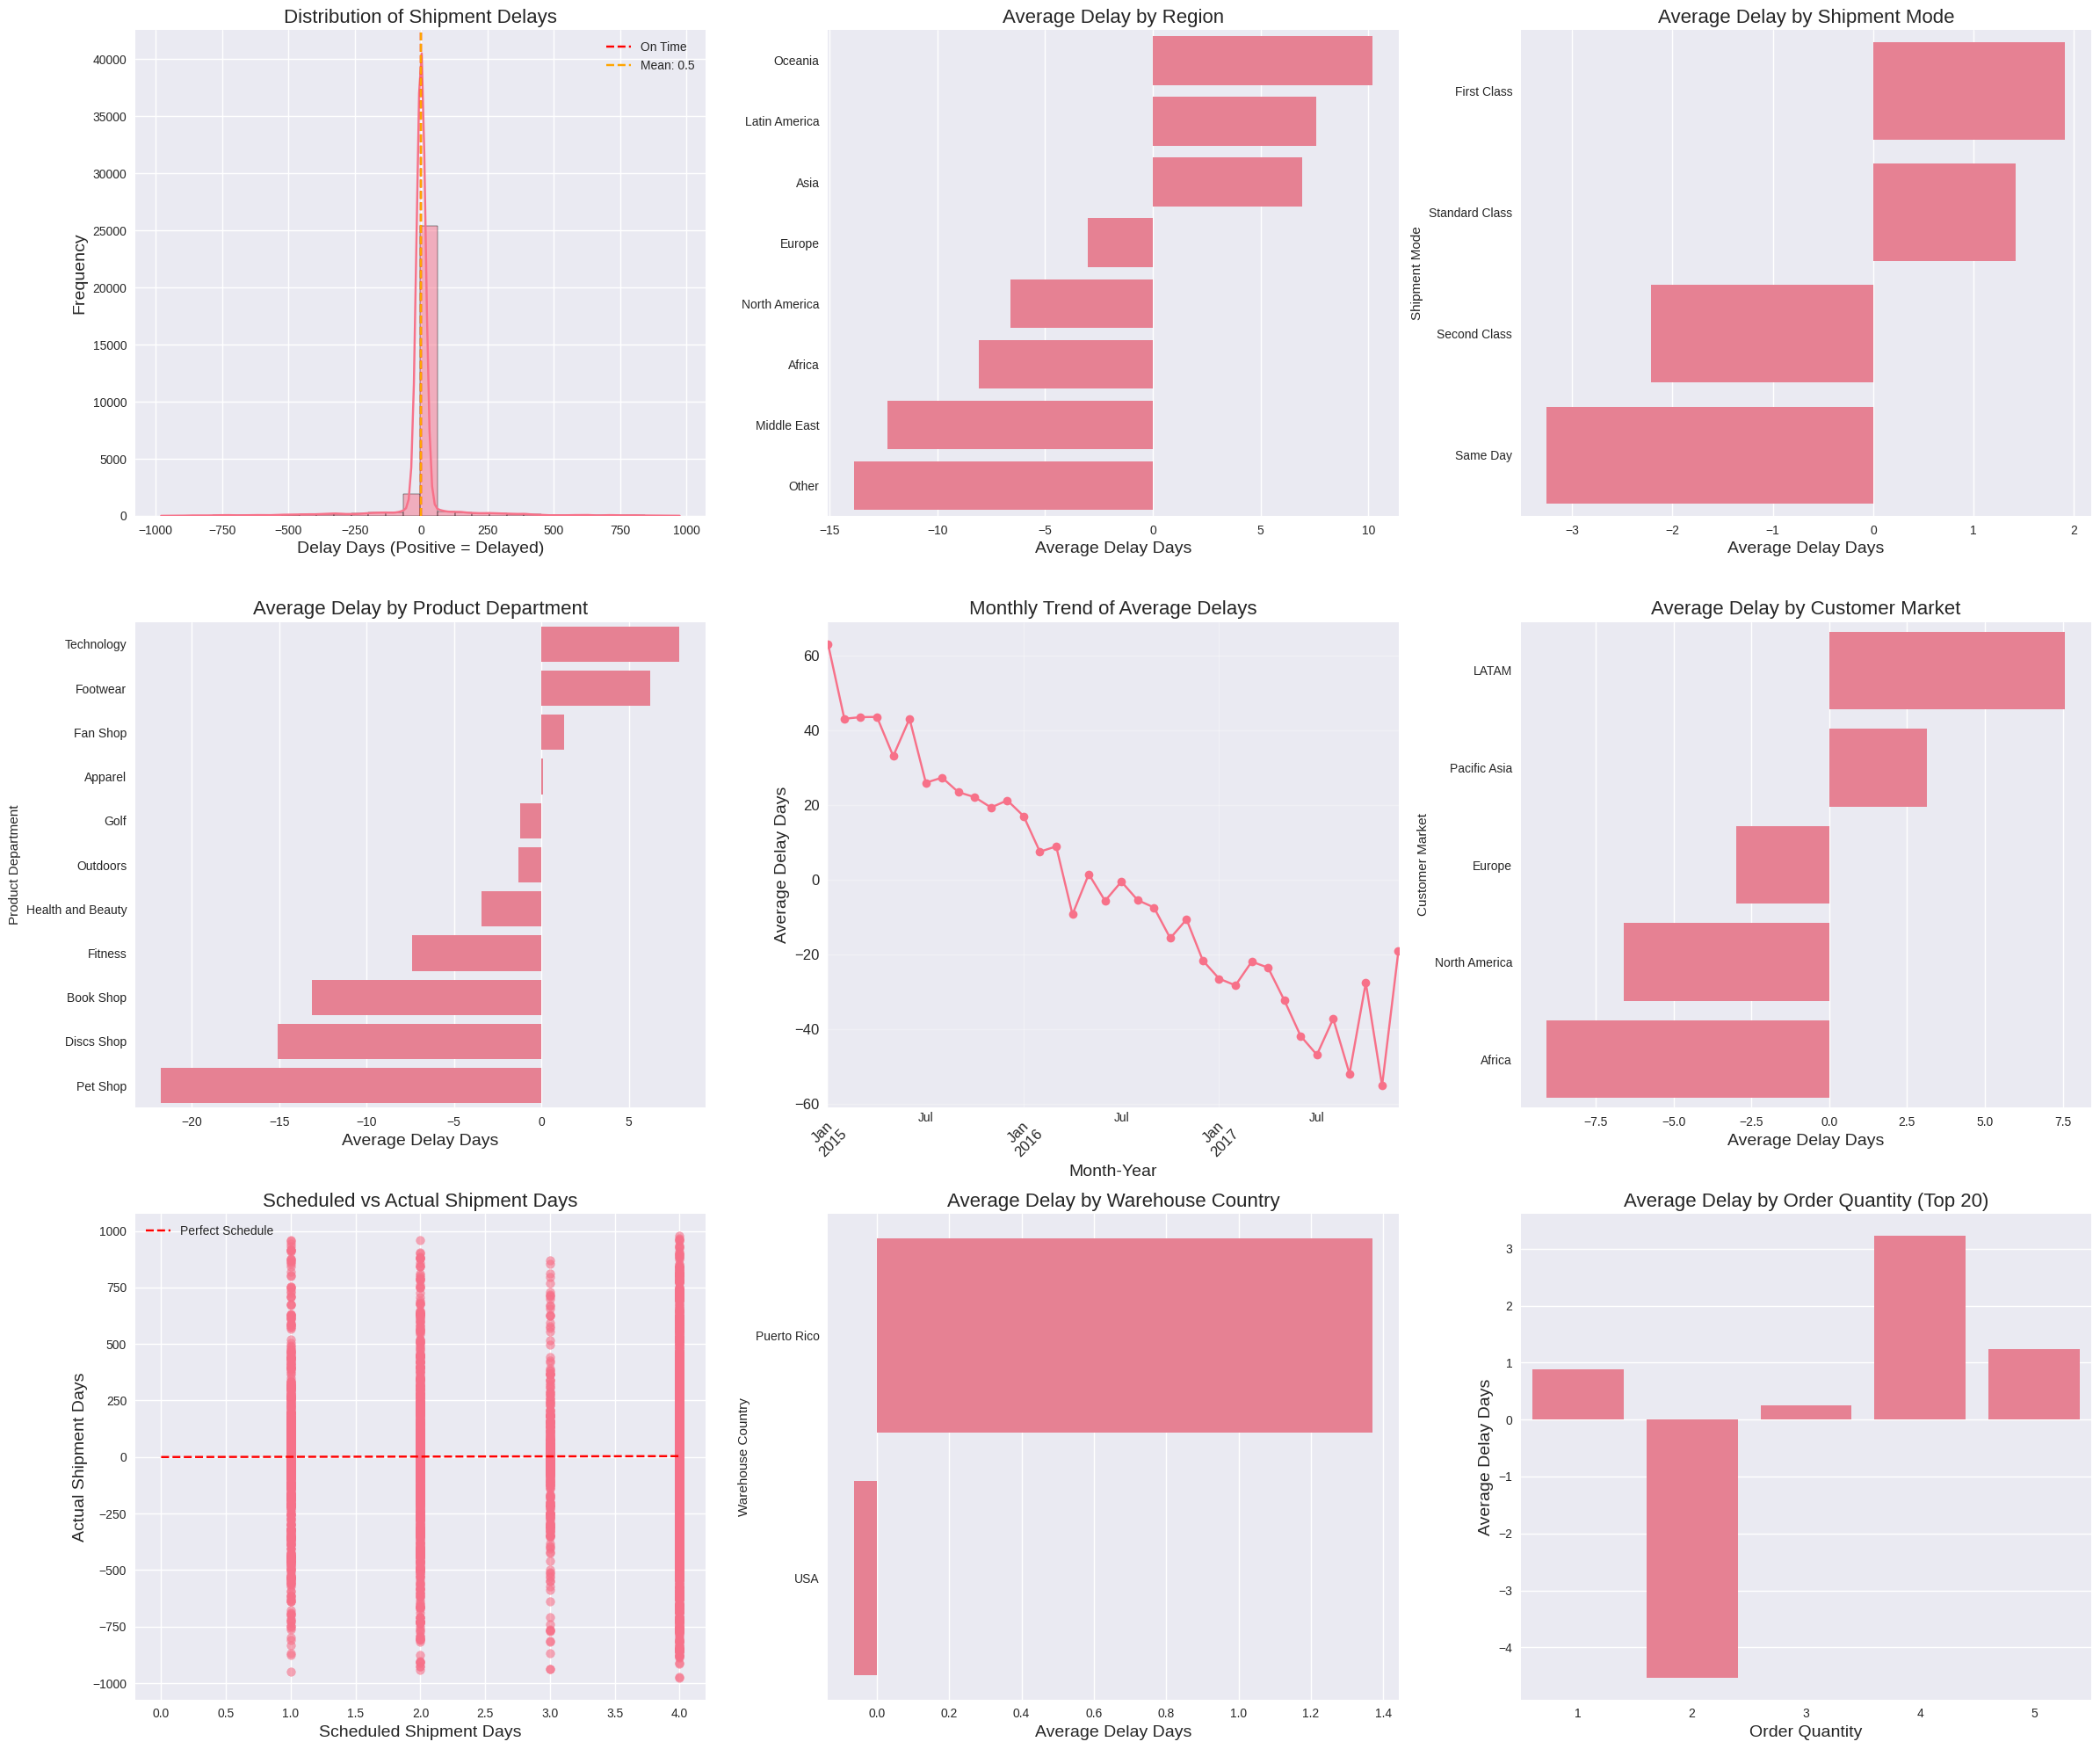

In [40]:
create_supply_chain_visualizations(df)


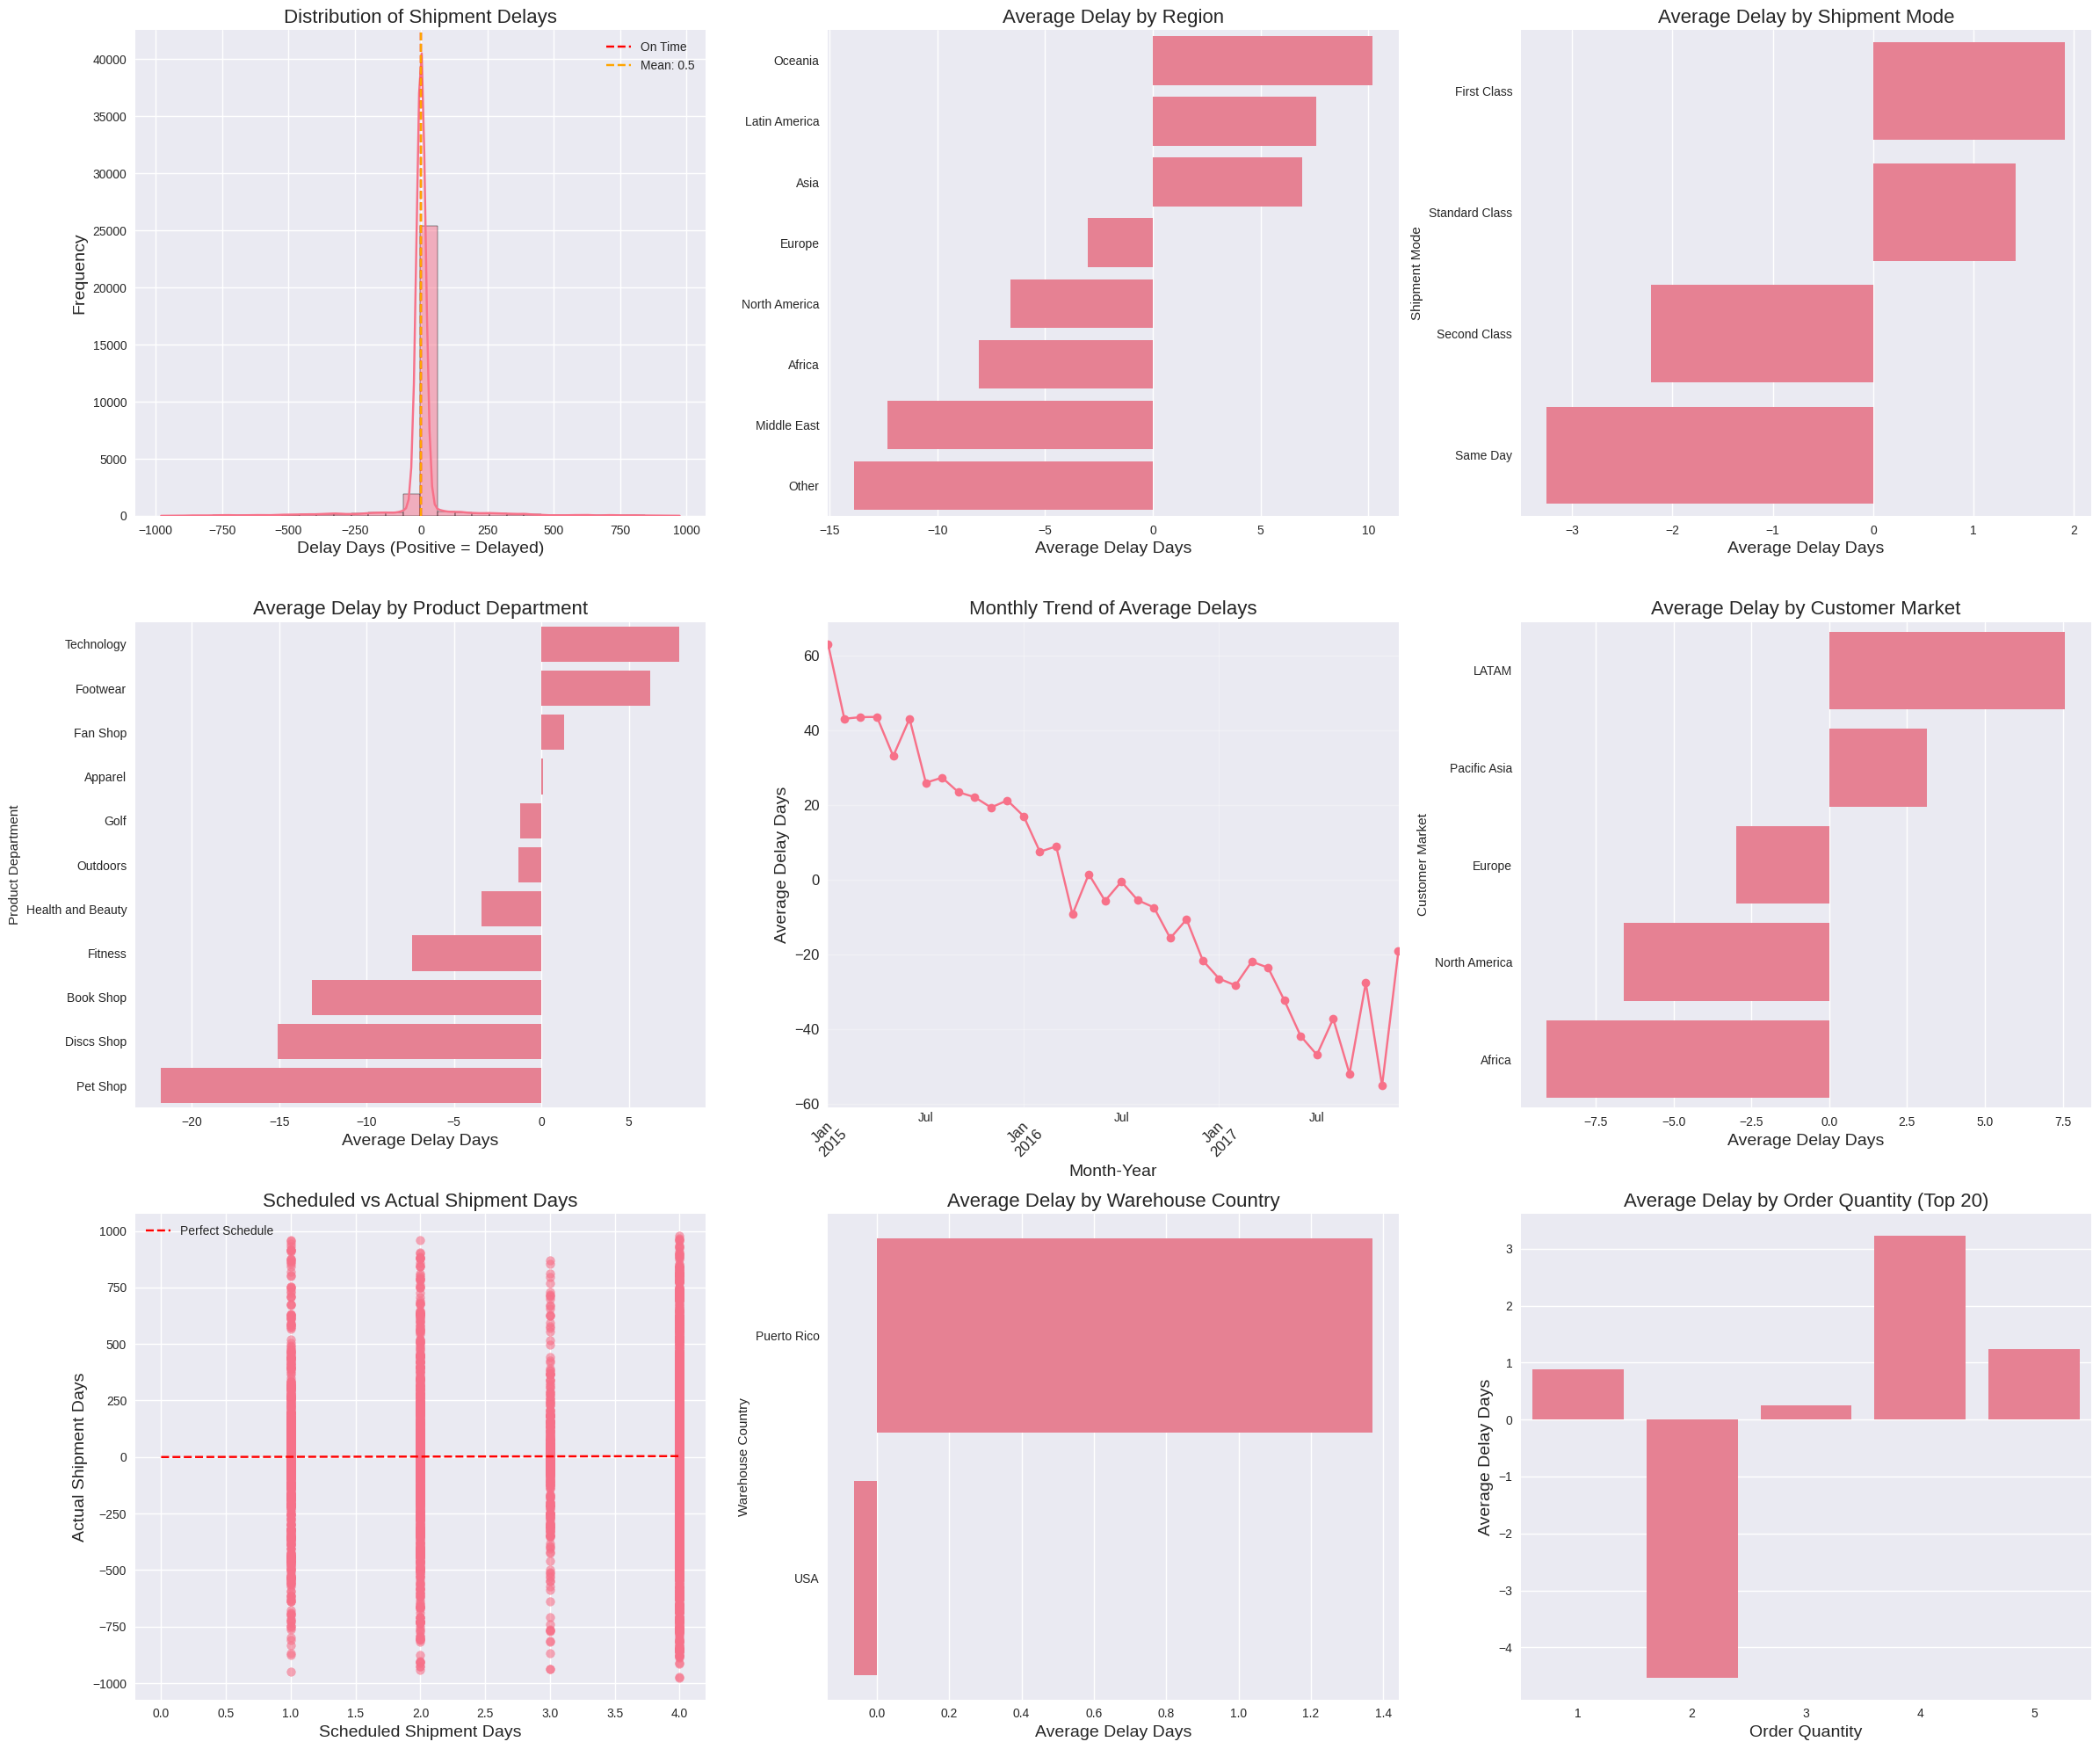

In [41]:

# Create the visualizations
try:
    create_supply_chain_visualizations(df)
except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
    print(f"\nWarning: Error creating visualizations: {e}")
    print("Continuing with other analyses...")


# Interactive visualizations with Plotly
def create_interactive_visualizations(dataframe):  # pylint: disable=redefined-outer-name
    """
    Create interactive visualizations using Plotly
    """
    df = dataframe  # noqa: F841  # pylint: disable=redefined-outer-name

    # 1. Global delay heatmap by region and shipment mode
    try:
        delay_heatmap_data = df.pivot_table(
            values="Delay Days", index="Region", columns="Shipment Mode", aggfunc="mean"
        ).fillna(0)

        if not delay_heatmap_data.empty:
            fig1 = px.imshow(
                delay_heatmap_data,
                title="Average Delay Days by Region and Shipment Mode",
                color_continuous_scale="RdBu_r",
                aspect="auto",
            )
            fig1.show()
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error creating heatmap: {e}")

    # 2. Time series of delays
    try:
        monthly_trend = (
            df.groupby("Order Month-Year")
            .agg({"Delay Days": "mean", "Order Quantity": "sum"})
            .reset_index()
        )
        if not monthly_trend.empty:
            monthly_trend["Order Month-Year"] = monthly_trend[
                "Order Month-Year"
            ].astype(str)
            monthly_trend = monthly_trend.dropna(subset=["Delay Days"])

            if not monthly_trend.empty:
                fig2 = px.line(
                    monthly_trend,
                    x="Order Month-Year",
                    y="Delay Days",
                    title="Monthly Trend of Average Delivery Delays",
                    markers=True,
                )
                fig2.show()
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error creating time series: {e}")

    # 3. Delay distribution by product category
    try:
        valid_categories = df["Product Category"].dropna()
        if len(valid_categories) > 0:
            top_categories = valid_categories.value_counts().head(10).index
            df_top_categories = df[
                df["Product Category"].isin(top_categories) & df["Delay Days"].notna()
            ]

            if not df_top_categories.empty:
                fig3 = px.box(
                    df_top_categories,
                    x="Product Category",
                    y="Delay Days",
                    title="Delay Distribution by Product Category (Top 10)",
                )
                fig3.update_xaxes(tickangle=45)
                fig3.show()
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error creating product category box plot: {e}")

    # 4. Regional performance comparison
    try:
        regional_stats = (
            df.groupby("Region")
            .agg({"Delay Days": ["mean", "std", "count"], "Order Quantity": "sum"})
            .round(2)
        )
        regional_stats.columns = [
            "Avg Delay",
            "Std Delay",
            "Order Count",
            "Total Quantity",
        ]
        regional_stats = regional_stats.dropna(subset=["Avg Delay"])
        regional_stats = regional_stats.sort_values("Avg Delay", ascending=False)

        if not regional_stats.empty:
            # Fill NaN in Std Delay with 0 for error bars
            regional_stats["Std Delay"] = regional_stats["Std Delay"].fillna(0)
            fig4 = px.bar(
                regional_stats.reset_index(),
                x="Region",
                y="Avg Delay",
                error_y="Std Delay",
                title="Regional Performance: Average Delay with Standard Deviation",
                color="Avg Delay",
                color_continuous_scale="RdYlBu_r",
            )
            fig4.show()
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error creating regional performance chart: {e}")


In [42]:
# Create interactive visualizations
try:
    create_interactive_visualizations(df)
except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
    print(f"\nWarning: Error creating interactive visualizations: {e}")
    print("Continuing with other analyses...")


In [48]:

# Advanced analytics
def perform_advanced_analytics(dataframe):  # pylint: disable=redefined-outer-name
    """
    Perform advanced analytics on the supply chain data
    """
    df = dataframe  # noqa: F841  # pylint: disable=redefined-outer-name
    print("\n=== ADVANCED ANALYTICS ===")

    # 1. Delay correlation analysis
    try:
        numeric_df = df.select_dtypes(include=[np.number])
        # Filter out columns that are all NaN
        numeric_df = numeric_df.dropna(axis=1, how="all")

        if len(numeric_df.columns) > 1:
            correlation_matrix = numeric_df.corr()
            # Check if correlation matrix has valid data
            if not correlation_matrix.isna().all().all():
                plt.figure(figsize=(10, 8))
                sns.heatmap(
                    correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f"
                )
                plt.title("Correlation Matrix of Numerical Variables")
                plt.tight_layout()
                plt.show()
            else:
                print("Correlation matrix contains only NaN values.")
        elif len(numeric_df.columns) == 1:
            print("Only one numerical column found. Cannot compute correlations.")
        else:
            print("No numerical columns found for correlation analysis")
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error creating correlation matrix: {e}")

    # 2. Risk analysis: identify high-risk routes
    print("\n=== HIGH-RISK SUPPLY CHAIN ROUTES ===")
    try:
        # Filter out rows with missing delay data
        valid_routes_df = df[
            df["Delay Days"].notna()
            & df["Warehouse Country"].notna()
            & df["Customer Country"].notna()
        ]

        if len(valid_routes_df) > 0:
            risk_routes = (
                valid_routes_df.groupby(["Warehouse Country", "Customer Country"])
                .agg({"Delay Days": ["mean", "count"], "Order Quantity": "sum"})
                .round(2)
            )

            risk_routes.columns = ["Avg Delay", "Shipment Count", "Total Quantity"]
            risk_routes = risk_routes.dropna(subset=["Avg Delay", "Shipment Count"])

            if len(risk_routes) > 0 and risk_routes["Avg Delay"].notna().any():
                high_risk_routes = risk_routes[
                    (risk_routes["Avg Delay"] > risk_routes["Avg Delay"].mean())
                    & (
                        risk_routes["Shipment Count"]
                        > risk_routes["Shipment Count"].quantile(0.5)
                    )
                ].sort_values("Avg Delay", ascending=False)

                print(f"Number of high-risk routes: {len(high_risk_routes)}")
                if len(high_risk_routes) > 0:
                    print(high_risk_routes.head(10))
                else:
                    print("No high-risk routes identified based on the criteria.")
            else:
                print("Insufficient data for risk route analysis.")
        else:
            print("No valid route data available for analysis.")
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error in risk route analysis: {e}")

    # 3. Seasonal analysis
    print("\n=== SEASONAL DELAY PATTERNS ===")
    try:
        valid_month_df = df[df["Order Month"].notna() & df["Delay Days"].notna()]
        if len(valid_month_df) > 0:
            monthly_delay_pattern = (
                valid_month_df.groupby("Order Month")["Delay Days"].mean().dropna()
            )
            if len(monthly_delay_pattern) > 0:
                plt.figure(figsize=(12, 6))
                monthly_delay_pattern.plot(kind="bar", color="skyblue")
                plt.title("Average Delay by Month (Seasonal Pattern)")
                plt.xlabel("Month")
                plt.ylabel("Average Delay Days")
                plt.xticks(rotation=0)
                plt.grid(axis="y", alpha=0.3)
                plt.show()
            else:
                print("No valid monthly delay data available for seasonal analysis.")
        else:
            print(
                "No data available for seasonal analysis (missing month or delay data)."
            )
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error in seasonal analysis: {e}")

    # 4. Product category risk analysis
    print("\n=== PRODUCT CATEGORY RISK ANALYSIS ===")
    try:
        valid_category_df = df[
            df["Delay Days"].notna() & df["Product Category"].notna()
        ]

        if len(valid_category_df) > 0:
            category_risk = (
                valid_category_df.groupby("Product Category")
                .agg({"Delay Days": ["mean", "std", "count"], "Order Quantity": "sum"})
                .round(2)
            )
            category_risk.columns = [
                "Avg Delay",
                "Std Delay",
                "Shipment Count",
                "Total Quantity",
            ]
            category_risk = category_risk.dropna(subset=["Avg Delay", "Shipment Count"])

            if len(category_risk) > 0:
                # Filter categories with sufficient data
                min_count = category_risk["Shipment Count"].quantile(0.5)
                if pd.notna(min_count) and min_count > 0:
                    high_risk_categories = category_risk[
                        category_risk["Shipment Count"] > min_count
                    ].nlargest(10, "Avg Delay")

                    if len(high_risk_categories) > 0:
                        print(high_risk_categories)
                    else:
                        print(
                            "No high-risk categories identified based on the criteria."
                        )
                else:
                    print("Insufficient data for category risk analysis.")
            else:
                print("No valid category data available for analysis.")
        else:
            print("No valid product category data available.")
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"Error in product category risk analysis: {e}")



=== ADVANCED ANALYTICS ===


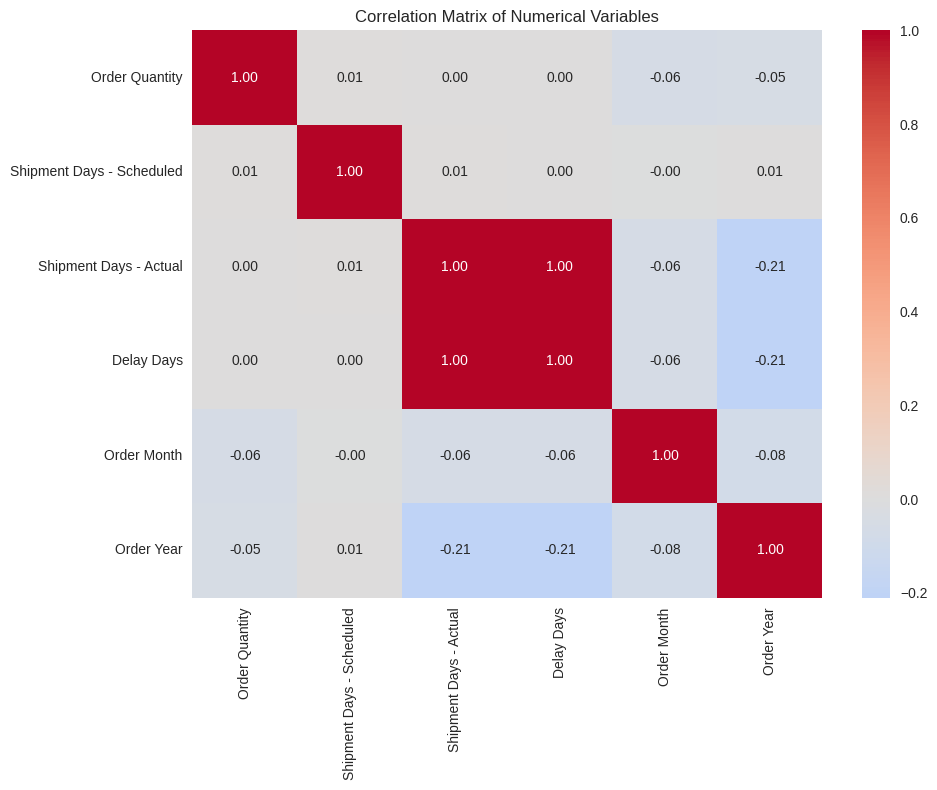


=== HIGH-RISK SUPPLY CHAIN ROUTES ===
Number of high-risk routes: 74
                                                Avg Delay  Shipment Count  \
Warehouse Country Customer Country                                          
Puerto Rico       Peru                              89.89              44   
                  Venezuela                         51.32              88   
                  Ireland                           44.78              32   
                  Dominican Republic                36.32             211   
                  Netherlands                       30.73             113   
                  Democratic Republic of Congo      28.71              52   
                  Colombia                          27.24              87   
                  Vietnam                           24.44              54   
                  Malaysia                          23.37              35   
USA               Argentina                         22.25             242   

     

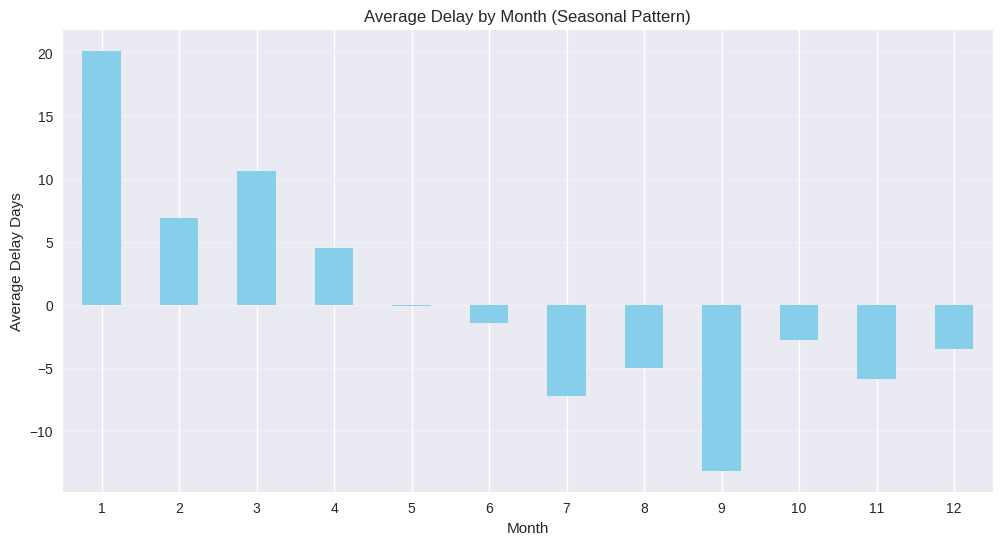


=== PRODUCT CATEGORY RISK ANALYSIS ===
                      Avg Delay  Std Delay  Shipment Count  Total Quantity
Product Category                                                          
Accessories               13.57     123.67             319             955
Cameras                    9.63     215.27             191             191
Electronics                7.69      68.39             520            1519
Cardio Equipment           5.33     211.19            2190            6614
Indoor/Outdoor Games       3.63     153.21            3416           10164
Golf Balls                 2.92     158.13             225             670
Men's Footwear             2.46     109.51            3855            3855
Fishing                    2.18      83.11            2878            2878
Water Sports               0.77      42.81            2688            2688
Toys                       0.71       2.31              73              73


In [49]:
# Perform advanced analytics
try:
    perform_advanced_analytics(df)
except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
    print(f"\nWarning: Error in advanced analytics: {e}")
    print("Continuing with summary...")

In [51]:
# Summary statistics and key insights
def generate_insights_summary(dataframe):  # pylint: disable=redefined-outer-name
    """
    Generate summary insights from the analysis
    """
    df = dataframe  # noqa: F841  # pylint: disable=redefined-outer-name
    print("\n" + "=" * 50)
    print("KEY INSIGHTS SUMMARY")
    print("=" * 50)

    # Overall performance
    valid_delays_summary = df["Delay Days"].dropna()
    if len(valid_delays_summary) > 0:
        on_time_rate = (valid_delays_summary <= 0).mean() * 100
        avg_delay = valid_delays_summary.mean()
    else:
        on_time_rate = 0
        avg_delay = 0

    print(" Overall Performance:")
    print(f"   • On-time delivery rate: {on_time_rate:.1f}%")
    print(f"   • Average delay: {avg_delay:.1f} days")
    print(f"   • Total shipments analyzed: {len(df):,}")

In [ ]:

    # Worst performing regions
    region_delays = df.groupby("Region")["Delay Days"].mean().dropna()
    if len(region_delays) > 0:
        worst_regions = region_delays.nlargest(3)
        print("\n Highest Risk Regions:")
        for region, delay in worst_regions.items():
            print(f"   • {region}: {delay:.1f} days average delay")

        # Best performing regions
        best_regions = region_delays.nsmallest(3)
        print("\n Best Performing Regions:")
        for region, delay in best_regions.items():
            print(f"   • {region}: {delay:.1f} days average delay")

    # Shipment mode performance
    mode_delays = df.groupby("Shipment Mode")["Delay Days"].mean().dropna()
    if len(mode_delays) > 0:
        mode_performance = mode_delays.sort_values()
        print("\n Shipment Mode Performance:")
        for mode, delay in mode_performance.items():
            print(f"   • {mode}: {delay:.1f} days average delay")

    # High-risk products
    dept_delays = df.groupby("Product Department")["Delay Days"].mean().dropna()
    if len(dept_delays) > 0:
        high_risk_products = dept_delays.nlargest(3)
        print("\n High-Risk Product Departments:")
        for dept, delay in high_risk_products.items():
            print(f"   • {dept}: {delay:.1f} days average delay")

    # Seasonal insights
    monthly_delays = df.groupby("Order Month")["Delay Days"].mean().dropna()
    if len(monthly_delays) > 0:
        worst_month = monthly_delays.idxmax()
        best_month = monthly_delays.idxmin()
        print("\n Seasonal Patterns:")
        print(f"   • Worst month for delays: Month {worst_month}")
        print(f"   • Best month for deliveries: Month {best_month}")



 Highest Risk Regions:
   • Oceania: 10.2 days average delay
   • Latin America: 7.6 days average delay
   • Asia: 6.9 days average delay

 Best Performing Regions:
   • Other: -13.9 days average delay
   • Middle East: -12.3 days average delay
   • Africa: -8.1 days average delay

 Shipment Mode Performance:
   • Same Day: -3.3 days average delay
   • Second Class: -2.2 days average delay
   • Standard Class: 1.4 days average delay
   • First Class: 1.9 days average delay

 High-Risk Product Departments:
   • Technology: 7.9 days average delay
   • Footwear: 6.2 days average delay
   • Fan Shop: 1.3 days average delay

 Seasonal Patterns:
   • Worst month for delays: Month 1
   • Best month for deliveries: Month 9


In [53]:

# Generate insights summary
try:
    generate_insights_summary(df)
except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
    print(f"\nWarning: Error generating insights: {e}")



KEY INSIGHTS SUMMARY
 Overall Performance:
   • On-time delivery rate: 56.5%
   • Average delay: 0.5 days
   • Total shipments analyzed: 30,871


In [56]:
# Export key metrics for further analysis
def export_key_metrics(dataframe):  # pylint: disable=redefined-outer-name
    """
    Export key metrics and processed data for further analysis
    """
    df = dataframe  # noqa: F841  # pylint: disable=redefined-outer-name
    # Create summary dataframe
    valid_delays_export = df["Delay Days"].dropna()
    if len(valid_delays_export) > 0:
        summary_metrics = {
            "Total_Shipments": len(df),
            "On_Time_Rate": (valid_delays_export <= 0).mean(),
            "Avg_Delay_Days": valid_delays_export.mean(),
            "Max_Delay": valid_delays_export.max(),
            "Min_Delay": valid_delays_export.min(),
            "Delayed_Shipments_Pct": (valid_delays_export > 0).mean(),
            "Early_Shipments_Pct": (valid_delays_export < 0).mean(),
        }
    else:
        summary_metrics = {
            "Total_Shipments": len(df),
            "On_Time_Rate": 0.0,
            "Avg_Delay_Days": 0.0,
            "Max_Delay": 0.0,
            "Min_Delay": 0.0,
            "Delayed_Shipments_Pct": 0.0,
            "Early_Shipments_Pct": 0.0,
        }

    summary_df = pd.DataFrame([summary_metrics])
    # Use current working directory instead of __file__ for notebooks
    export_output_dir = os.getcwd()
    summary_path = os.path.join(export_output_dir, "supply_chain_summary_metrics.csv")
    processed_path = os.path.join(export_output_dir, "processed_supply_chain_data.csv")

    summary_df.to_csv(summary_path, index=False)

    # Export processed data with delays
    try:
        df.to_csv(processed_path, index=False)
        print("\n Data exported successfully:")
        print(f"   • {summary_path}")
        print(f"   • {processed_path}")
    except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
        print(f"\n Warning: Could not export processed data: {e}")
        # Still try to export summary
        try:
            summary_df.to_csv(summary_path, index=False)
            print(f"   • {summary_path} (summary only)")
        except (ValueError, KeyError, AttributeError, TypeError, OSError) as e2:  # pylint: disable=broad-exception-caught
            print(f"   Error: Could not export summary either: {e2}")


# Export metrics
try:
    export_key_metrics(df)
except (ValueError, KeyError, AttributeError, TypeError, OSError) as e:  # pylint: disable=broad-exception-caught
    print(f"\nWarning: Error exporting metrics: {e}")

print("\n" + "=" * 50)
print("Analysis complete! Check the visualizations above.")
print("=" * 50)



 Data exported successfully:
   • /content/supply_chain_summary_metrics.csv
   • /content/processed_supply_chain_data.csv

Analysis complete! Check the visualizations above.


In [58]:
# Print summary of outputs
print("\n=== OUTPUT SUMMARY ===")
output_dir = os.getcwd()  # Use current working directory instead of __file__
summary_file = os.path.join(output_dir, "supply_chain_summary_metrics.csv")
processed_file = os.path.join(output_dir, "processed_supply_chain_data.csv")

if os.path.exists(summary_file):
    print(f"✓ Summary metrics saved: {summary_file}")
if os.path.exists(processed_file):
    print(f"✓ Processed data saved: {processed_file}")
print("\nScript execution completed successfully!")



=== OUTPUT SUMMARY ===
✓ Summary metrics saved: /content/supply_chain_summary_metrics.csv
✓ Processed data saved: /content/processed_supply_chain_data.csv

Script execution completed successfully!
